In [1]:
%load_ext autoreload

%autoreload 2

import skimage
import holodeck as holo
from importlib import reload
from holodeck import sbi as hsbi
from sbi import utils as sbutils
from sbi import analysis
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi import inference
import h5py
import numpy as np
import torch


In [2]:
spectra = h5py.File("/home/dave/data/sbi-holodeck/sam_lib.hdf5","r")

In [2]:
kde_library_store = np.load("/home/dave/data/sbi-holodeck/holodeck-kdes.npz")

In [3]:
kdes = kde_library_store["log10rho_kdes"]
theta = torch.from_numpy(kde_library_store["theta"]).to("cuda",dtype=torch.float32)

In [4]:
prior = sbutils.BoxUniform(
    low=theta.min(axis=0)[0], high=theta.max(axis=0)[0],device="cuda"
)

In [5]:
import matplotlib.pyplot as plt

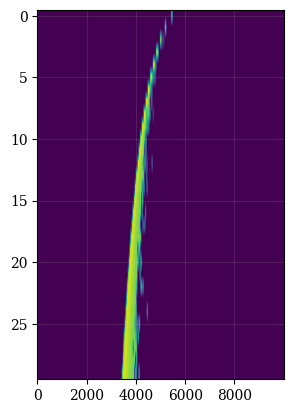

In [46]:
plt.imshow(kdes.to("cpu")[300], aspect=500)#.flatten())#[:-791].reshape(547, -1))

In [6]:
kde_transform = skimage.transform.resize(kdes, (kdes.shape[0],128,128), mode="reflect")

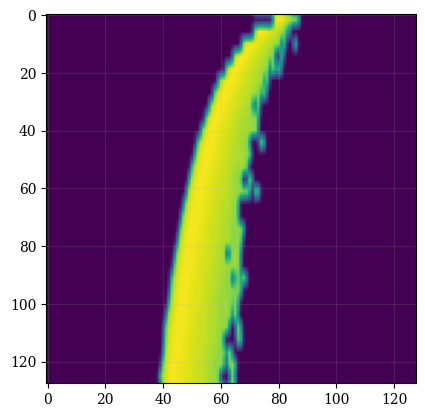

In [36]:
plt.imshow(kde_transform.to("cpu")[300])

In [13]:
kdes_cuda = torch.from_numpy(kde_transform).to("cuda", dtype=torch.float32)

In [121]:
embedding_net = hsbi.sbi.CIFAR10Model()

In [122]:
neural_posterior = sbutils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

In [123]:
inference = SNPE(prior=prior, density_estimator=neural_posterior, device="cuda")

In [124]:
density_estimator = inference.append_simulations(theta, kdes_cuda).train()

 Neural network successfully converged after 306 epochs.

In [132]:
posterior = inference.build_posterior(density_estimator)

In [ ]:
samples = posterior.set_default_x(kdes_cuda[173]).sample((50000,))

NameError: name 'kdes_cuda' is not defined

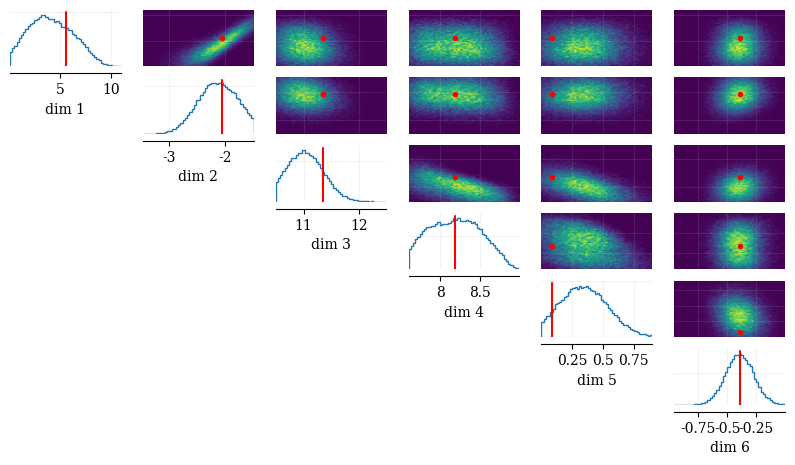

In [141]:
fig, ax = analysis.pairplot(
    samples.to("cpu"),
    points=theta[173].to("cpu"),
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(10, 5),
) 

In [142]:
import pickle
with open("posterior-sbi-2023-10-13.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [2]:
test_spectra = h5py.File("/home/dave/data/sbi-holodeck/sam_lib_v2.hdf5","r")
holo.sbi.sbi.make_kdes_for_library(test_spectra, save=True)

Found 0.00e+00/2.00e+03 = 0.00e+00 samples with NaN entries.  Removing them from library.
setting aside 0.0 of samples (0) for testing, and choosing 30 frequencies


(array([[ 5.92924881e+00, -2.89131957e+00,  1.21257356e+01,
          7.64898174e+00,  7.68085952e-01, -9.31854556e-01],
        [ 6.00857368e+00, -3.12800242e+00,  1.14743142e+01,
          8.90844142e+00,  1.59560055e-01, -5.92359034e-02],
        [ 3.10329581e+00, -2.75510400e+00,  1.12941000e+01,
          8.47717707e+00,  1.34503354e-01, -3.49271274e-01],
        ...,
        [ 5.57769789e+00, -2.56505266e+00,  1.23191606e+01,
          7.84413343e+00,  4.78681849e-01, -2.32181937e-01],
        [ 3.38171209e+00, -2.87059025e+00,  1.11732448e+01,
          8.82869703e+00,  1.11822912e-02, -1.44247882e-02],
        [ 1.39577315e+00, -1.87038920e+00,  1.08647824e+01,
          7.63118707e+00,  1.30347836e-01, -8.87181947e-01]]),
 array([[[-36.04365339, -36.04365339, -36.04365339, ..., -36.04365339,
          -36.04365339, -36.04365339],
         [-36.04365339, -36.04365339, -36.04365339, ..., -36.04365339,
          -36.04365339, -36.04365339],
         [-36.04365339, -36.04365339, -

In [5]:
import pickle
with open("posterior-sbi-2023-10-13.pkl", "rb") as handle:
    posterior = pickle.load(handle)

In [6]:
test_kde_library_store = np.load("/home/dave/data/sbi-holodeck/holodeck-kdes-test.npz")

In [7]:
kdes_test = test_kde_library_store["log10rho_kdes"]
theta_test = torch.from_numpy(test_kde_library_store["theta"]).to("cuda",dtype=torch.float32)

In [8]:
test_kde_transform = skimage.transform.resize(kdes_test, (kdes_test.shape[0],128,128), mode="reflect")

In [9]:
kdes_cuda_test = torch.from_numpy(test_kde_transform).to("cuda", dtype=torch.float32)

In [42]:
samples_test = posterior.set_default_x(kdes_cuda_test[1800]).sample((500000,))

Drawing 500000 posterior samples:   0%|          | 0/500000 [00:00<?, ?it/s]

In [12]:
test_spectra = h5py.File("/home/dave/data/sbi-holodeck/sam_lib_v2.hdf5","r")

In [34]:
test_spectra.attrs['param_names'].astype(str)

array(['hard_time', 'gsmf_phi0', 'gsmf_mchar0_log10', 'mmb_mamp_log10',
       'mmb_scatter_dex', 'hard_gamma_inner'], dtype='<U17')

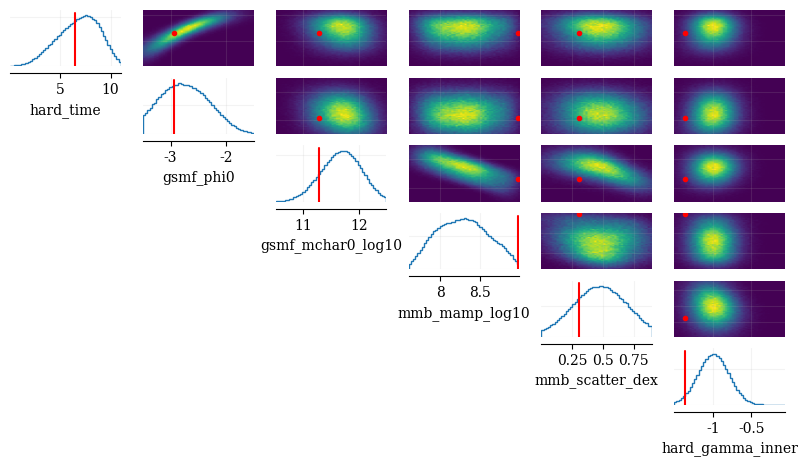

In [43]:
fig, ax = analysis.pairplot(
    samples_test.to("cpu"),
    points=theta_test[1800].to("cpu"),
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(10, 5),
    labels=test_spectra.attrs['param_names'].astype(str),
) 

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

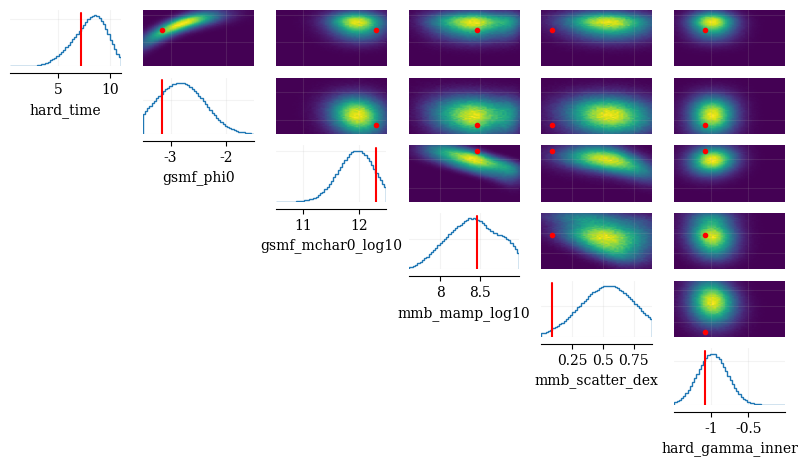

In [47]:
param_ind = 15
n_samples = 1_000_000
fig, ax = analysis.pairplot(
    posterior.set_default_x(kdes_cuda_test[param_ind]).sample((n_samples,)).to("cpu"),
    points=theta_test[param_ind].to("cpu"),
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(10, 5),
    labels=test_spectra.attrs['param_names'].astype(str),
) 

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

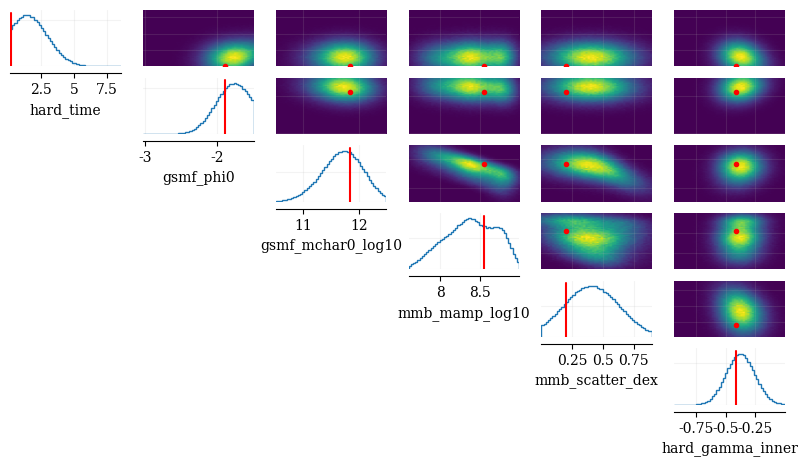

In [48]:
param_ind = 985
n_samples = 1_000_000
fig, ax = analysis.pairplot(
    posterior.set_default_x(kdes_cuda_test[param_ind]).sample((n_samples,)).to("cpu"),
    points=theta_test[param_ind].to("cpu"),
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(10, 5),
    labels=test_spectra.attrs['param_names'].astype(str),
) 